## Introduction to Data Science

### Predictive Analysis - numerical data with regularization

#### Inspired by [this repo](https://github.com/Weesper1985/Predict_real_estate_prices), codes [here](https://www.kaggle.com/dhainjeamita/linear-regression/code) and [here](https://www.kaggle.com/vikrishnan/house-sales-price-using-regression). Used [this data](https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime). Tried using [feature selection](http://scikit-learn.org/stable/modules/feature_selection.html) techniques

In [1]:
import os
import sys
import time
import pickle
import itertools
import pandas as pd
import numpy as np
import pylab
from itertools import cycle

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, ElasticNet
from sklearn.linear_model import lasso_path, enet_path
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, validation_curve
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

%matplotlib inline
#%matplotlib notebook
#matplotlib.rcdefaults()
#matplotlib.verbose.set_level('silent')

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


#### Importing the datasets and exploring data

In [2]:
datapath = "../datasets/CSVs/"
outputs = "../outputs/"

In [3]:
! ls ../datasets/CSVs/communities.*

../datasets/CSVs/communities.data  ../datasets/CSVs/communities.names


In [4]:
! head -n10 ../datasets/CSVs/communities.names

Title: Communities and Crime

Abstract: Communities within the United States. The data combines socio-economic data 
from the 1990 US Census, law enforcement data from the 1990 US LEMAS survey, and crime 
data from the 1995 FBI UCR.

-----------------------------------------------------------------------------------------

Data Set Characteristics:  Multivariate
Attribute Characteristics: Real


In [5]:
! head -n5 ../datasets/CSVs/communities.data

8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.9,0.12,0.17,0.34,0.47,0.29,0.32,0.2,1,0.37,0.72,0.34,0.6,0.29,0.15,0.43,0.39,0.4,0.39,0.32,0.27,0.27,0.36,0.41,0.08,0.19,0.1,0.18,0.48,0.27,0.68,0.23,0.41,0.25,0.52,0.68,0.4,0.75,0.75,0.35,0.55,0.59,0.61,0.56,0.74,0.76,0.04,0.14,0.03,0.24,0.27,0.37,0.39,0.07,0.07,0.08,0.08,0.89,0.06,0.14,0.13,0.33,0.39,0.28,0.55,0.09,0.51,0.5,0.21,0.71,0.52,0.05,0.26,0.65,0.14,0.06,0.22,0.19,0.18,0.36,0.35,0.38,0.34,0.38,0.46,0.25,0.04,0,0.12,0.42,0.5,0.51,0.64,0.03,0.13,0.96,0.17,0.06,0.18,0.44,0.13,0.94,0.93,0.03,0.07,0.1,0.07,0.02,0.57,0.29,0.12,0.26,0.2,0.06,0.04,0.9,0.5,0.32,0.14,0.2
53,?,?,Tukwilacity,1,0,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,0.02,1,0.31,0.72,0.11,0.45,0.25,0.29,0.39,0.29,0.37,0.38,0.33,0.16,0.3,0.22,0.35,0.01,0.24,0.14,0.24,0.3,0.27,0.73,0.57,0.15,0.42,0.36,1,0.63,0.91,1,0.29,0.43,0.47,0.6,0.39,0.46,0.53,0,0.24,0.01,0.52,0.62,0.64,0.63,0.25,0.27,0.25,0.23,0.84,0.1,0.16,0.1,0.17,0.29,0.17,0.26,0.2,0.82,0,0.02,0.79,0.24,0.02,0.25,0.65,0

In [6]:
names = open(os.path.join(datapath, 'communities.names'), 'r').readlines()
attributes = [n for n in names if n.startswith('@attribute')]
attributes = [a.split()[1] for a in attributes]
print(len(attributes))
print(attributes)

128
['state', 'county', 'community', 'communityname', 'fold', 'population', 'householdsize', 'racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp', 'agePct12t21', 'agePct12t29', 'agePct16t24', 'agePct65up', 'numbUrban', 'pctUrban', 'medIncome', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'medFamInc', 'perCapInc', 'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'NumUnderPov', 'PctPopUnderPov', 'PctLess9thGrade', 'PctNotHSGrad', 'PctBSorMore', 'PctUnemployed', 'PctEmploy', 'PctEmplManu', 'PctEmplProfServ', 'PctOccupManu', 'PctOccupMgmtProf', 'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv', 'TotalPctDiv', 'PersPerFam', 'PctFam2Par', 'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMomYoungKids', 'PctWorkMom', 'NumIlleg', 'PctIlleg', 'NumImmig', 'PctImmigRecent', 'PctImmigRec5', 'PctImmigRec8', 'PctImmigRec10', 'PctRecentImmig', 'PctRecImmig5', 'PctRecImmig8', 'PctRecImmig10', 'PctSpeakEn

In [7]:
df = pd.read_csv(os.path.join(datapath, 'communities.data'), 
                 na_values='?', 
                 header=None, 
                 names=attributes)
df.head()

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03


In [8]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 128 columns):
state                    1994 non-null int64
county                   820 non-null float64
community                817 non-null float64
communityname            1994 non-null object
fold                     1994 non-null int64
population               1994 non-null float64
householdsize            1994 non-null float64
racepctblack             1994 non-null float64
racePctWhite             1994 non-null float64
racePctAsian             1994 non-null float64
racePctHisp              1994 non-null float64
agePct12t21              1994 non-null float64
agePct12t29              1994 non-null float64
agePct16t24              1994 non-null float64
agePct65up               1994 non-null float64
numbUrban                1994 non-null float64
pctUrban                 1994 non-null float64
medIncome                1994 non-null float64
pctWWage                 1994 non-null float64
pctWFa

In [9]:
#non numeric
columns1 = ['state', 'county', 'community', 'communityname', 'fold']

#many missing values
columns2 = ['LemasSwornFT', 'LemasSwFTPerPop', 'LemasSwFTFieldOps', 'LemasSwFTFieldPerPop', 
            'LemasTotalReq',  'LemasTotReqPerPop', 'PolicReqPerOffic', 'PolicPerPop', 
            'RacialMatchCommPol', 'PctPolicWhite', 'PctPolicBlack', 'PctPolicHisp', 
            'PctPolicAsian', 'PctPolicMinor', 'OfficAssgnDrugUnits', 'NumKindsDrugsSeiz',
            'PolicAveOTWorked', 'PolicCars', 'PolicOperBudg', 'LemasPctPolicOnPatr',
            'LemasGangUnitDeploy', 'PolicBudgPerPop', 'OtherPerCap']

df.drop(columns=columns1, inplace=True)
df.drop(columns=columns2, inplace=True)

In [10]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 100 columns):
population               1994 non-null float64
householdsize            1994 non-null float64
racepctblack             1994 non-null float64
racePctWhite             1994 non-null float64
racePctAsian             1994 non-null float64
racePctHisp              1994 non-null float64
agePct12t21              1994 non-null float64
agePct12t29              1994 non-null float64
agePct16t24              1994 non-null float64
agePct65up               1994 non-null float64
numbUrban                1994 non-null float64
pctUrban                 1994 non-null float64
medIncome                1994 non-null float64
pctWWage                 1994 non-null float64
pctWFarmSelf             1994 non-null float64
pctWInvInc               1994 non-null float64
pctWSocSec               1994 non-null float64
pctWPubAsst              1994 non-null float64
pctWRetire               1994 non-null float64

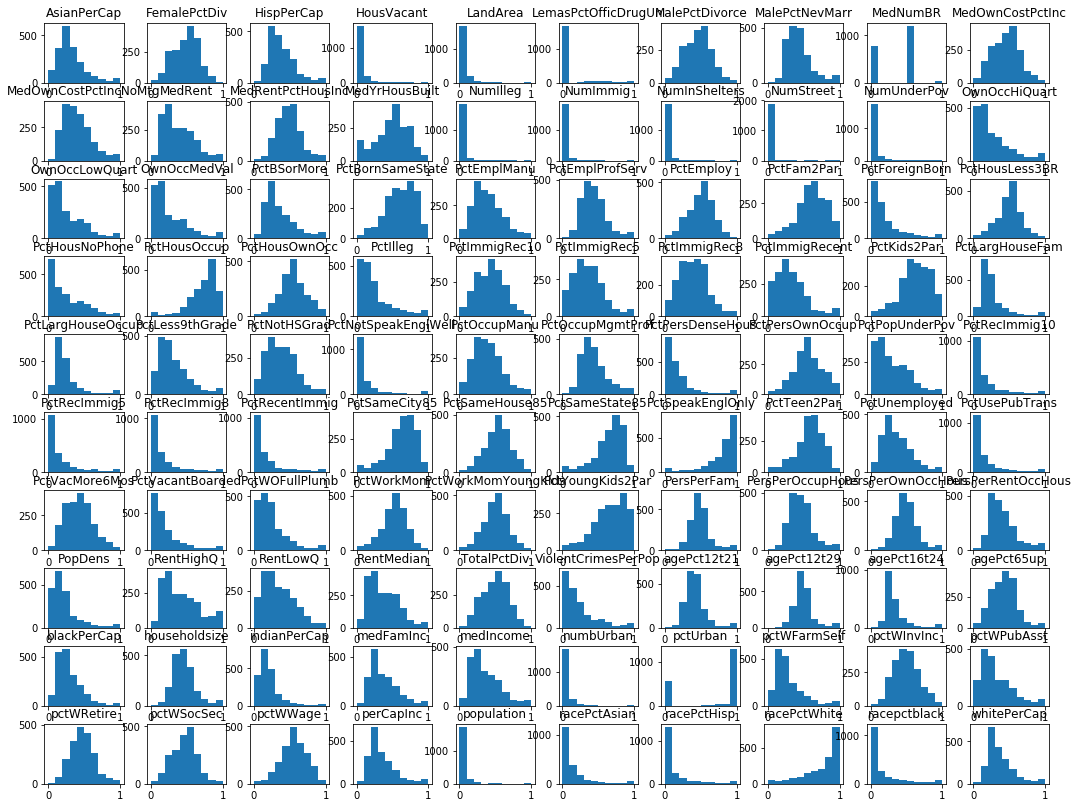

In [11]:
# histograms
df.hist(bins=10,figsize=(18,14),grid=False);

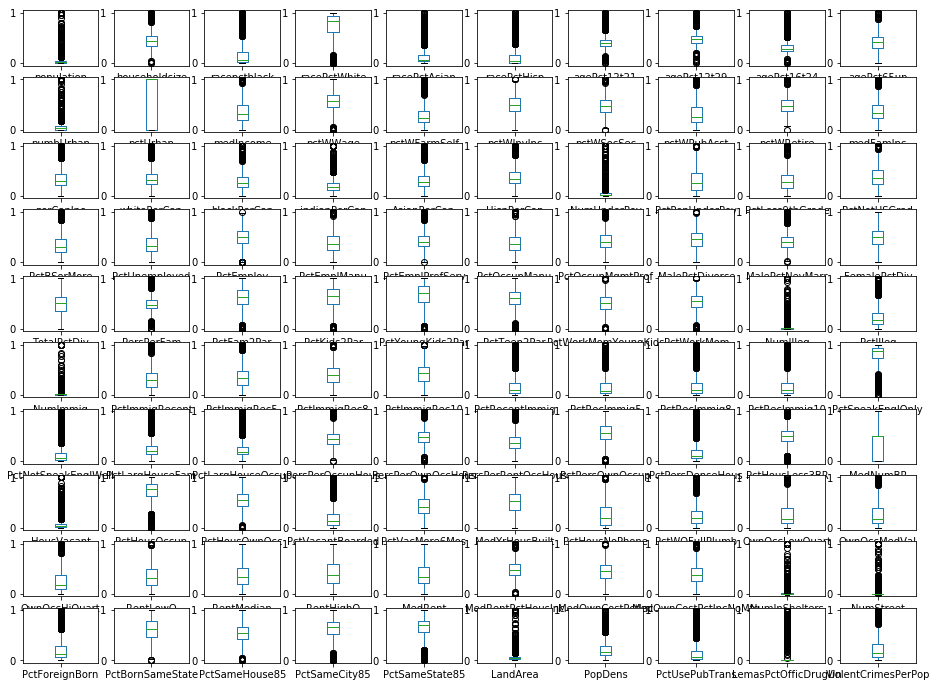

In [12]:
df.plot(kind='box', subplots=True, layout=(10,10), sharex=False, sharey=False, figsize=(16,12))
plt.show()

In [13]:
# correlation
pd.set_option('precision', 2)
df.corr(method='pearson')

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
population,1.00e+00,-4.61e-02,2.31e-01,-3.01e-01,1.82e-01,1.56e-01,6.37e-03,0.13,7.56e-02,-1.02e-01,...,1.73e-01,-0.13,-1.24e-01,1.61e-03,-8.96e-02,7.14e-01,2.32e-01,2.70e-01,4.66e-01,0.37
householdsize,-4.61e-02,1.00e+00,-6.71e-02,-2.36e-01,2.02e-01,4.69e-01,5.20e-01,0.37,2.95e-01,-6.13e-01,...,3.11e-01,-0.05,-5.78e-02,-1.03e-01,-3.28e-03,-1.51e-02,-4.07e-03,-5.15e-02,-9.44e-02,-0.03
racepctblack,2.31e-01,-6.71e-02,1.00e+00,-7.94e-01,-1.07e-01,-6.66e-02,1.22e-01,0.15,1.34e-01,5.29e-02,...,-9.81e-02,0.09,-4.56e-02,5.64e-02,-2.89e-03,1.50e-01,9.51e-02,1.47e-01,2.61e-01,0.63
racePctWhite,-3.01e-01,-2.36e-01,-7.94e-01,1.00e+00,-2.70e-01,-4.44e-01,-1.94e-01,-0.27,-1.84e-01,1.36e-01,...,-3.73e-01,0.11,1.65e-01,-1.97e-02,3.24e-02,-1.31e-01,-3.37e-01,-2.16e-01,-2.76e-01,-0.68
racePctAsian,1.82e-01,2.02e-01,-1.07e-01,-2.70e-01,1.00e+00,2.67e-01,-2.50e-02,0.10,5.28e-02,-2.72e-01,...,6.57e-01,-0.41,-1.90e-01,-1.95e-01,-1.98e-01,-1.08e-03,3.90e-01,2.97e-01,1.02e-01,0.04
racePctHisp,1.56e-01,4.69e-01,-6.66e-02,-4.44e-01,2.67e-01,1.00e+00,1.46e-01,0.21,8.63e-02,-2.28e-01,...,6.84e-01,-0.26,-1.66e-01,1.45e-02,2.02e-04,1.16e-02,3.70e-01,7.84e-02,1.25e-01,0.29
agePct12t21,6.37e-03,5.20e-01,1.22e-01,-1.94e-01,-2.50e-02,1.46e-01,1.00e+00,0.82,8.95e-01,-4.11e-01,...,-6.85e-02,0.08,-3.57e-01,-3.61e-01,-1.51e-01,2.57e-02,-9.57e-02,-1.73e-01,1.30e-03,0.06
agePct12t29,1.30e-01,3.67e-01,1.53e-01,-2.67e-01,1.01e-01,2.06e-01,8.22e-01,1.00,9.34e-01,-5.21e-01,...,7.77e-02,-0.05,-5.59e-01,-5.06e-01,-3.18e-01,6.25e-02,1.20e-01,-2.35e-02,1.17e-01,0.15
agePct16t24,7.56e-02,2.95e-01,1.34e-01,-1.84e-01,5.28e-02,8.63e-02,8.95e-01,0.93,1.00e+00,-3.23e-01,...,5.59e-03,-0.01,-4.63e-01,-4.79e-01,-2.75e-01,3.16e-02,4.60e-02,-4.04e-02,8.32e-02,0.10
agePct65up,-1.02e-01,-6.13e-01,5.29e-02,1.36e-01,-2.72e-01,-2.28e-01,-4.11e-01,-0.52,-3.23e-01,1.00e+00,...,-1.40e-01,0.15,3.94e-01,3.73e-01,2.56e-01,-1.24e-01,1.54e-02,6.79e-03,-1.02e-02,0.07


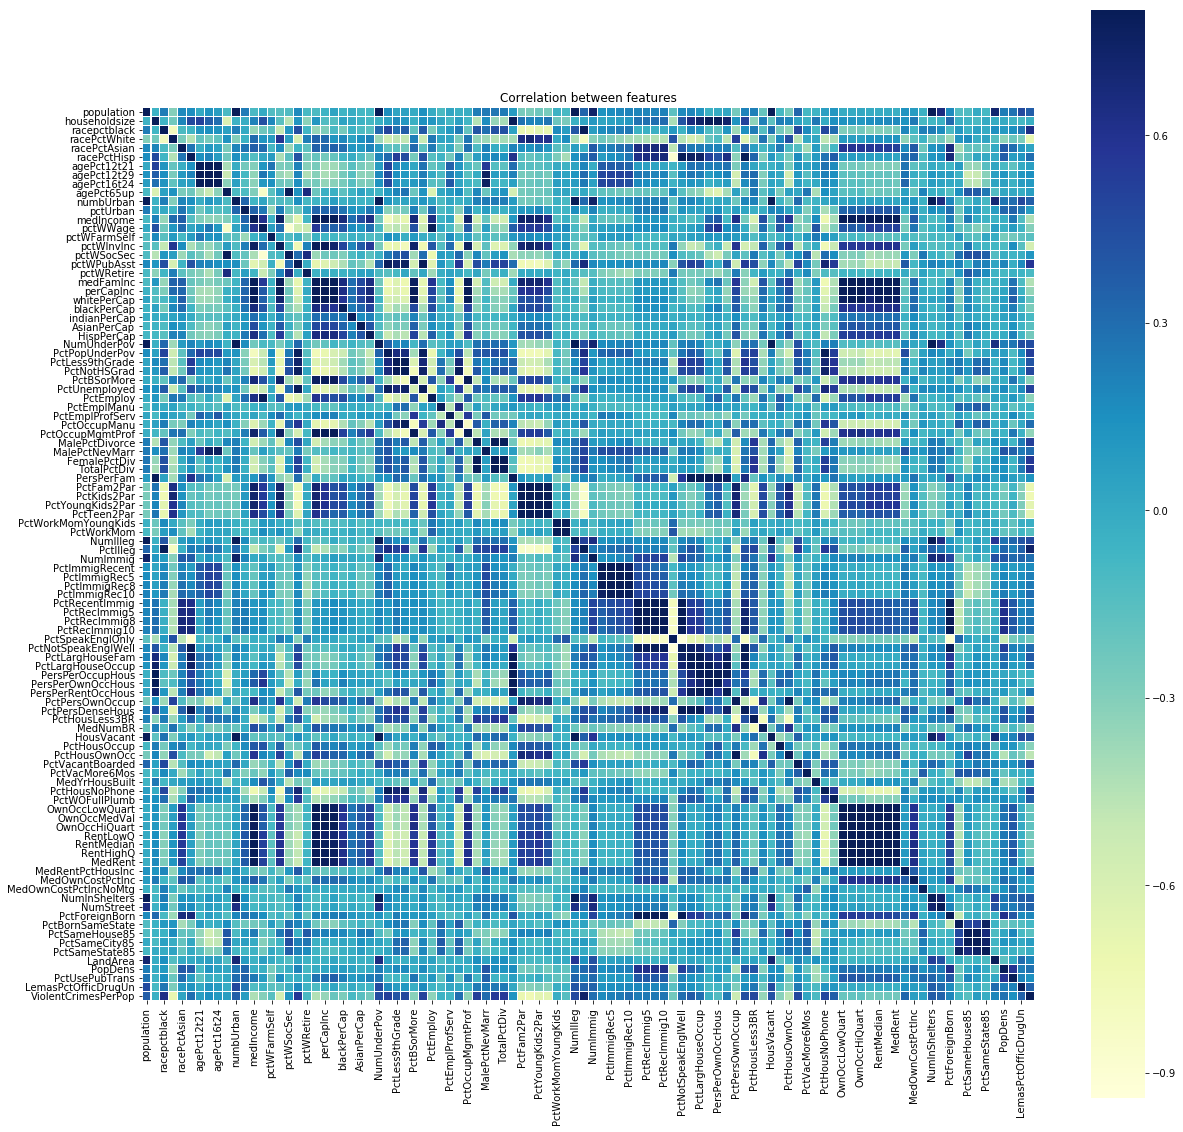

In [14]:
corr=df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, vmax=.8, linewidths=0.01,square=True,annot=False,cmap='YlGnBu',linecolor="white")
plt.title('Correlation between features');

In [15]:
crimes = df['ViolentCrimesPerPop']

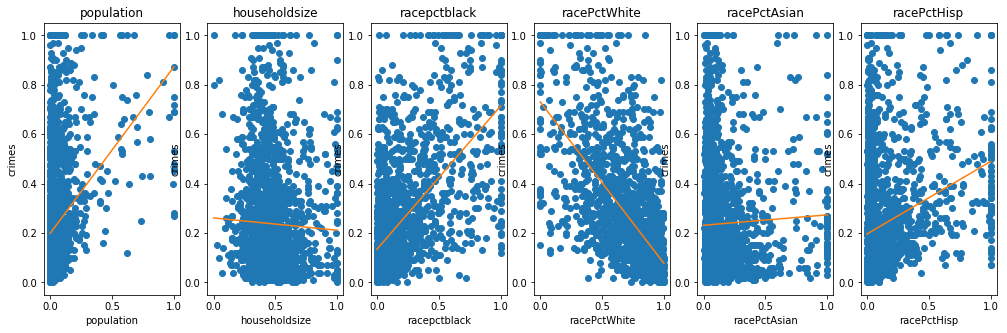

In [16]:
plt.figure(figsize=(20, 5))

for i, col in enumerate(df.columns[0:6]):
    plt.subplot(1, 7, i+1)
    x = df[col]
    y = crimes
    plt.plot(x, y, 'o')
    # Create regression line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('crimes')

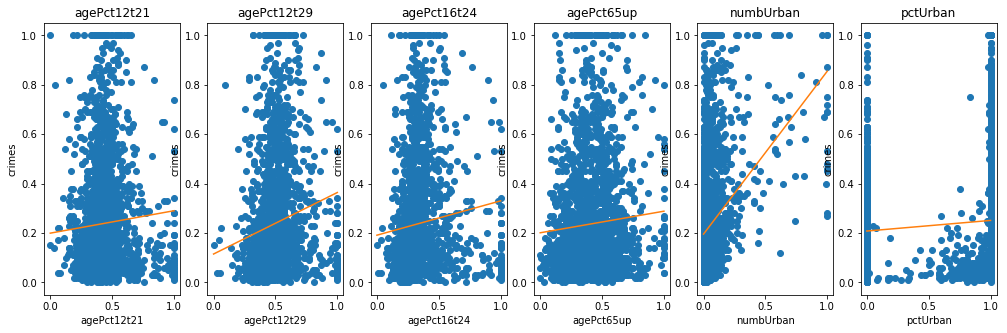

In [17]:
plt.figure(figsize=(20, 5))

for i, col in enumerate(df.columns[6:12]):
    plt.subplot(1, 7, i+1)
    x = df[col]
    y = crimes
    plt.plot(x, y, 'o')
    # Create regression line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('crimes')

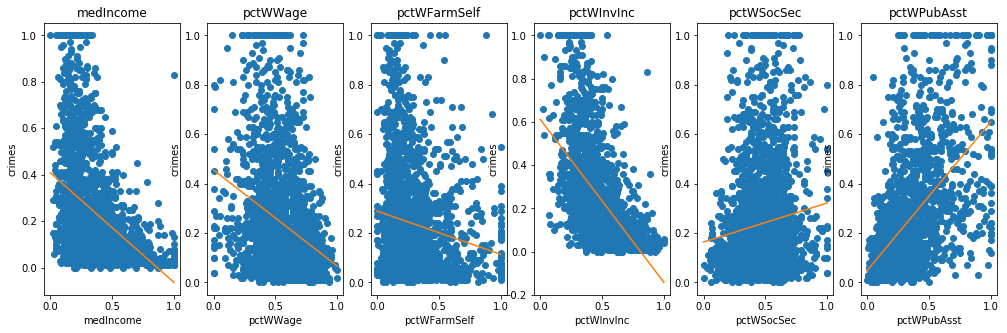

In [18]:
plt.figure(figsize=(20, 5))

for i, col in enumerate(df.columns[12:18]):
    plt.subplot(1, 7, i+1)
    x = df[col]
    y = crimes
    plt.plot(x, y, 'o')
    # Create regression line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('crimes')

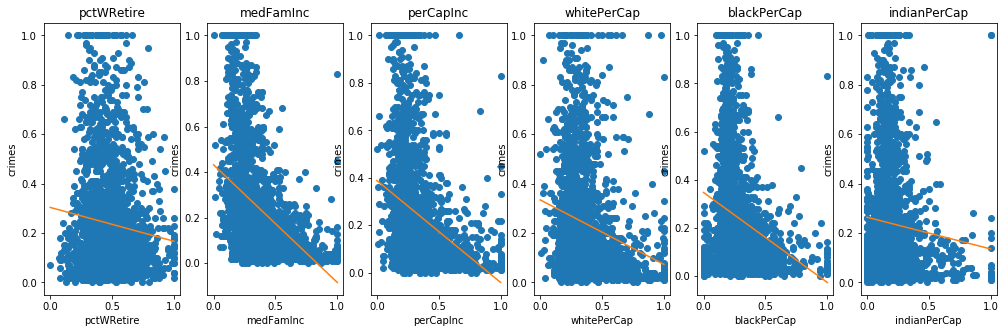

In [19]:
plt.figure(figsize=(20, 5))

for i, col in enumerate(df.columns[18:24]):
    plt.subplot(1, 7, i+1)
    x = df[col]
    y = crimes
    plt.plot(x, y, 'o')
    # Create regression line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('crimes')

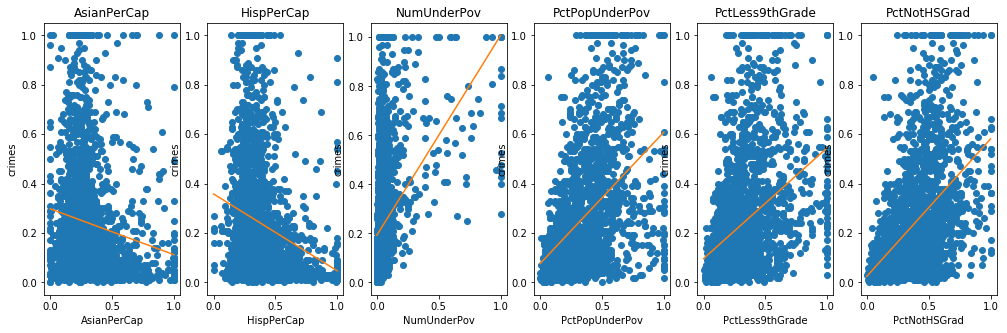

In [20]:
plt.figure(figsize=(20, 5))

for i, col in enumerate(df.columns[24:30]):
    plt.subplot(1, 7, i+1)
    x = df[col]
    y = crimes
    plt.plot(x, y, 'o')
    # Create regression line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('crimes')

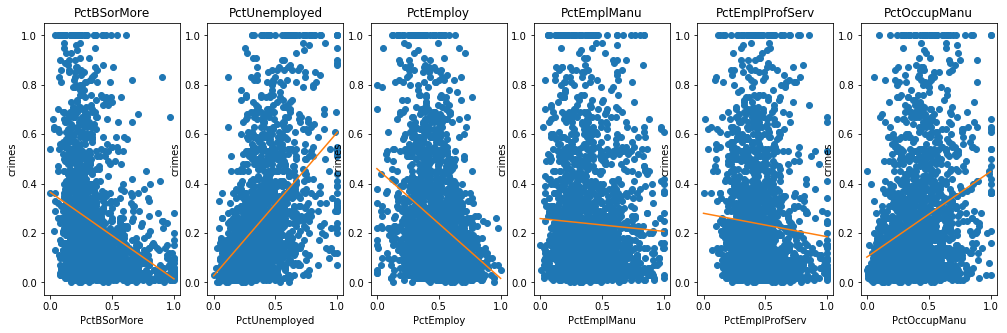

In [21]:
plt.figure(figsize=(20, 5))

for i, col in enumerate(df.columns[30:36]):
    plt.subplot(1, 7, i+1)
    x = df[col]
    y = crimes
    plt.plot(x, y, 'o')
    # Create regression line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('crimes')

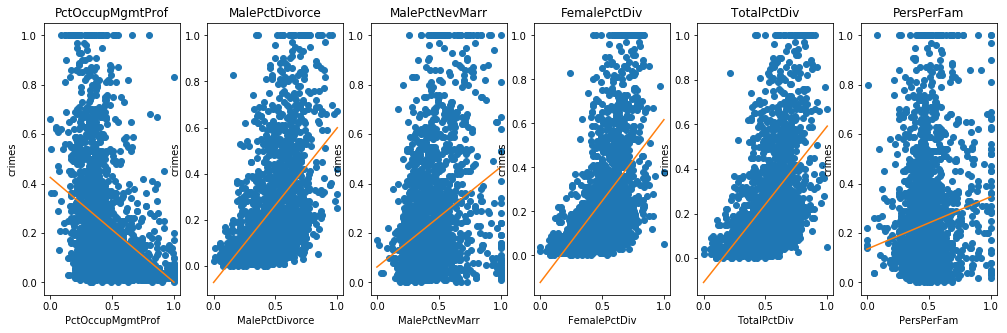

In [22]:
plt.figure(figsize=(20, 5))

for i, col in enumerate(df.columns[36:42]):
    plt.subplot(1, 7, i+1)
    x = df[col]
    y = crimes
    plt.plot(x, y, 'o')
    # Create regression line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('crimes')

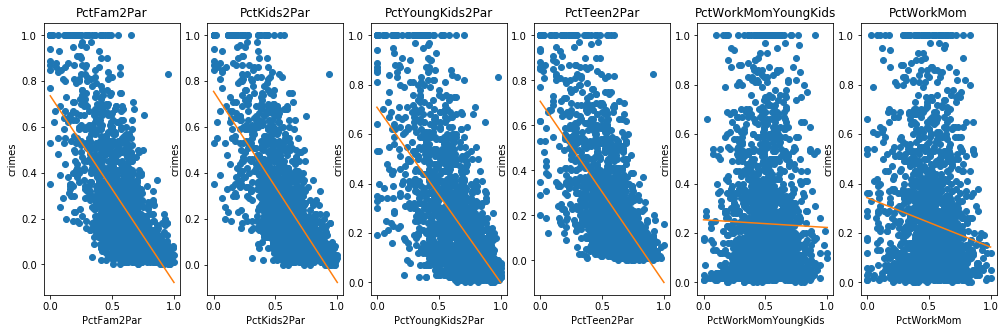

In [23]:
plt.figure(figsize=(20, 5))

for i, col in enumerate(df.columns[42:48]):
    plt.subplot(1, 7, i+1)
    x = df[col]
    y = crimes
    plt.plot(x, y, 'o')
    # Create regression line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('crimes')

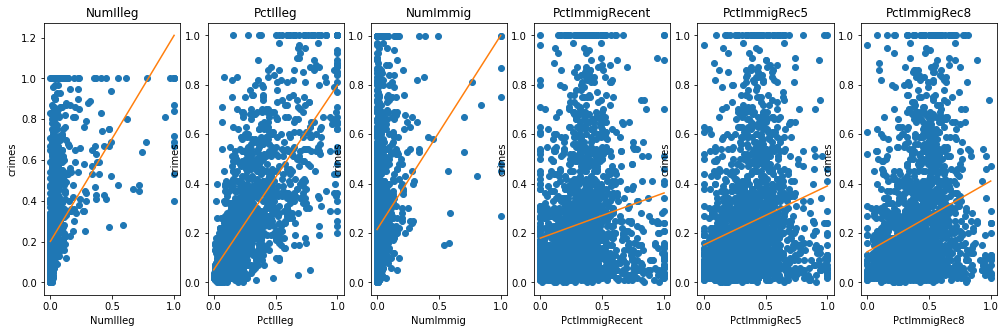

In [24]:
plt.figure(figsize=(20, 5))

for i, col in enumerate(df.columns[48:54]):
    plt.subplot(1, 7, i+1)
    x = df[col]
    y = crimes
    plt.plot(x, y, 'o')
    # Create regression line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('crimes')

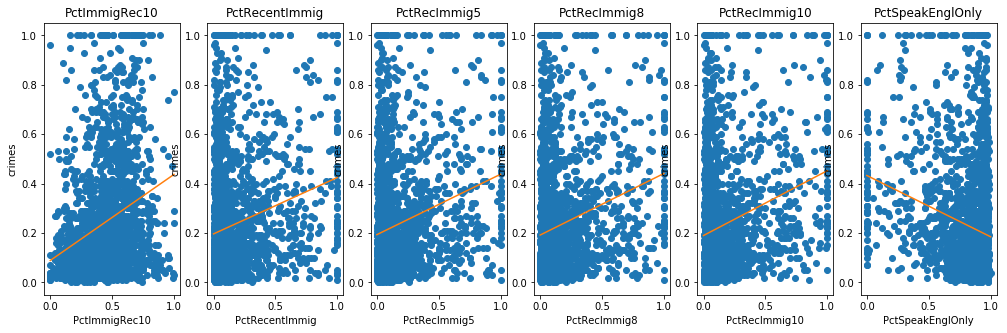

In [25]:
plt.figure(figsize=(20, 5))

for i, col in enumerate(df.columns[54:60]):
    plt.subplot(1, 7, i+1)
    x = df[col]
    y = crimes
    plt.plot(x, y, 'o')
    # Create regression line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('crimes')

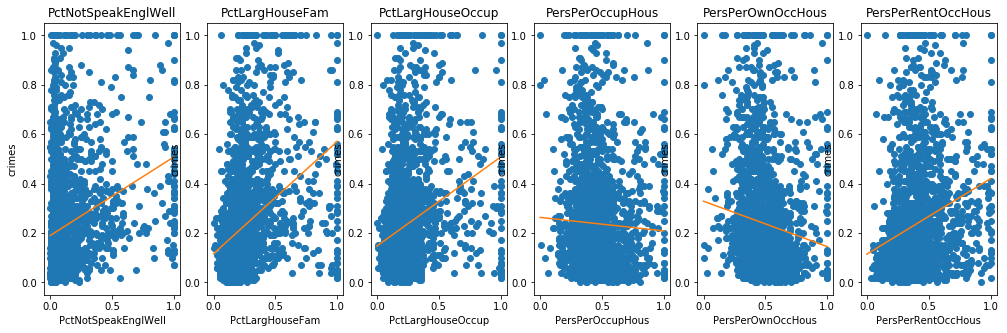

In [26]:
plt.figure(figsize=(20, 5))

for i, col in enumerate(df.columns[60:66]):
    plt.subplot(1, 7, i+1)
    x = df[col]
    y = crimes
    plt.plot(x, y, 'o')
    # Create regression line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('crimes')

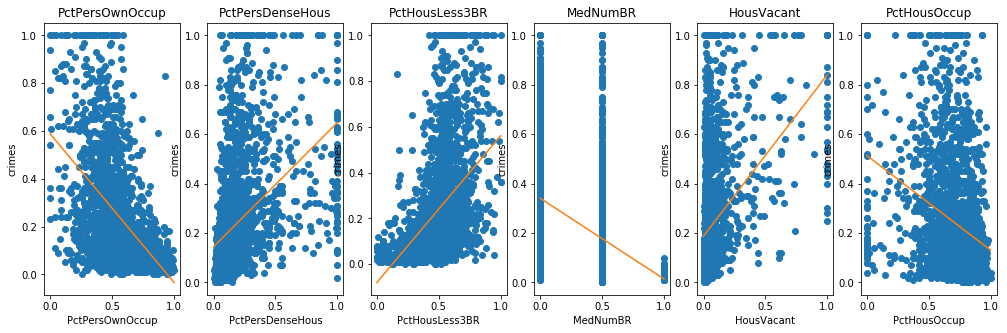

In [27]:
plt.figure(figsize=(20, 5))

for i, col in enumerate(df.columns[66:72]):
    plt.subplot(1, 7, i+1)
    x = df[col]
    y = crimes
    plt.plot(x, y, 'o')
    # Create regression line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('crimes')

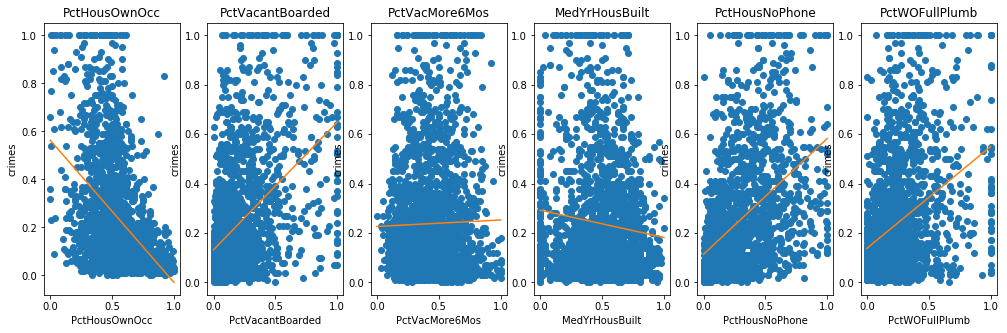

In [28]:
plt.figure(figsize=(20, 5))

for i, col in enumerate(df.columns[72:78]):
    plt.subplot(1, 7, i+1)
    x = df[col]
    y = crimes
    plt.plot(x, y, 'o')
    # Create regression line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('crimes')

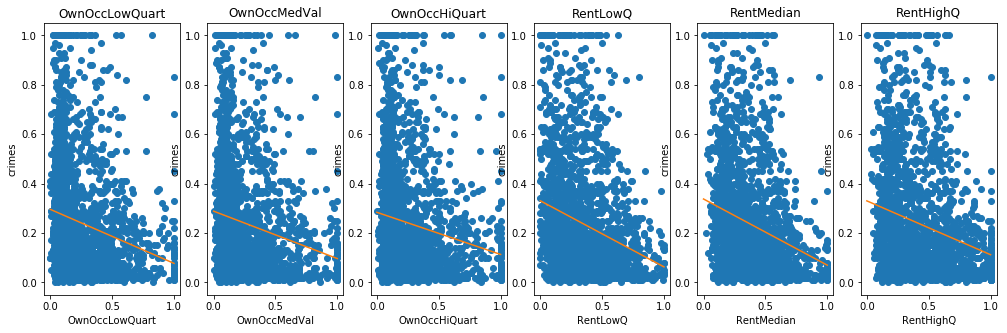

In [29]:
plt.figure(figsize=(20, 5))

for i, col in enumerate(df.columns[78:84]):
    plt.subplot(1, 7, i+1)
    x = df[col]
    y = crimes
    plt.plot(x, y, 'o')
    # Create regression line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('crimes')

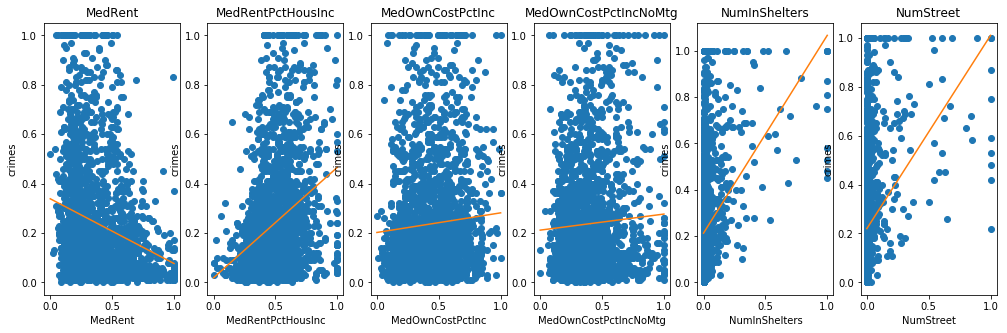

In [30]:
plt.figure(figsize=(20, 5))

for i, col in enumerate(df.columns[84:90]):
    plt.subplot(1, 7, i+1)
    x = df[col]
    y = crimes
    plt.plot(x, y, 'o')
    # Create regression line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('crimes')

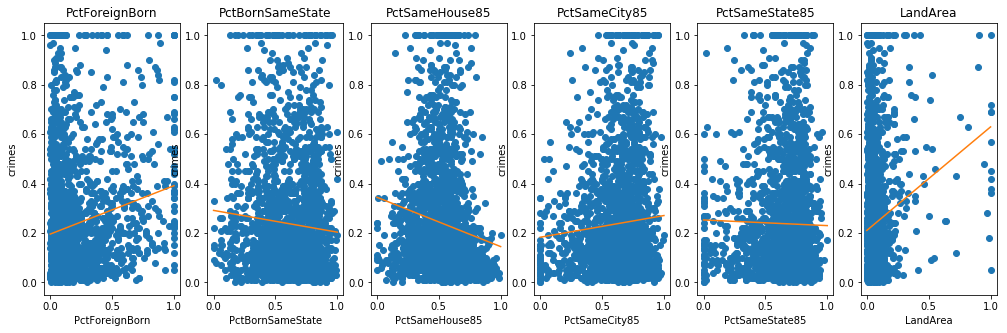

In [31]:
plt.figure(figsize=(20, 5))

for i, col in enumerate(df.columns[90:96]):
    plt.subplot(1, 7, i+1)
    x = df[col]
    y = crimes
    plt.plot(x, y, 'o')
    # Create regression line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('crimes')

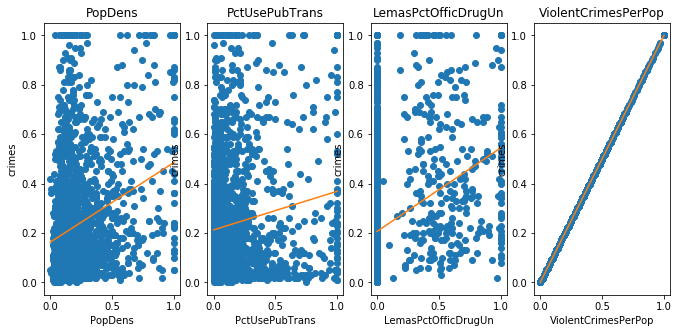

In [32]:
plt.figure(figsize=(20, 5))

for i, col in enumerate(df.columns[96:]):
    plt.subplot(1, 7, i+1)
    x = df[col]
    y = crimes
    plt.plot(x, y, 'o')
    # Create regression line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('crimes')

The point here is to test 'crimes' in a very lean way. 
We'll do this paying attention to: Histogram - Kurtosis and skewness. 
Normal probability plot - Data distribution should closely follow the diagonal that represents the normal distribution.

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


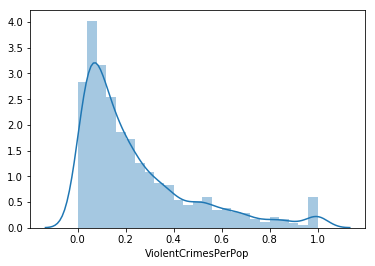

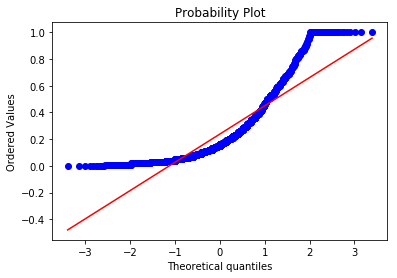

In [33]:
from scipy import stats
#histogram and normal probability plot
sns.distplot(crimes, hist=True);
fig = plt.figure()
res = stats.probplot(crimes, plot=plt)

In [34]:
#Prepare Data

# split into input (X) and output (Y) variables
X = df.values[:,0:-1]
y = df.values[:,99]

print(X.shape)
print(y.shape)

(1994, 99)
(1994,)


In [35]:
# Split-out validation dataset
validation_size = 0.20
seed = 0
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=validation_size, random_state=seed)

In [36]:
# Test options and evaluation metric using Root Mean Square error method
#http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

num_folds = 15
#score = 'neg_mean_squared_error'
score = 'r2'

In [37]:
# Spot Check Algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
models.append(('RIDGE', Ridge()))
models.append(('RIDGECV', RidgeCV()))
models.append(('MLPR', MLPRegressor()))

In [38]:
results1 = []
names1 = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=score)
    results1.append(cv_results)
    names1.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.640510 (0.051512)
LASSO: -0.014786 (0.021318)
EN: -0.014786 (0.021318)
KNN: 0.585169 (0.076732)
CART: 0.184466 (0.188314)
SVR: 0.650358 (0.041477)
RIDGE: 0.648789 (0.048226)
RIDGECV: 0.648789 (0.048226)
MLPR: 0.626141 (0.063297)


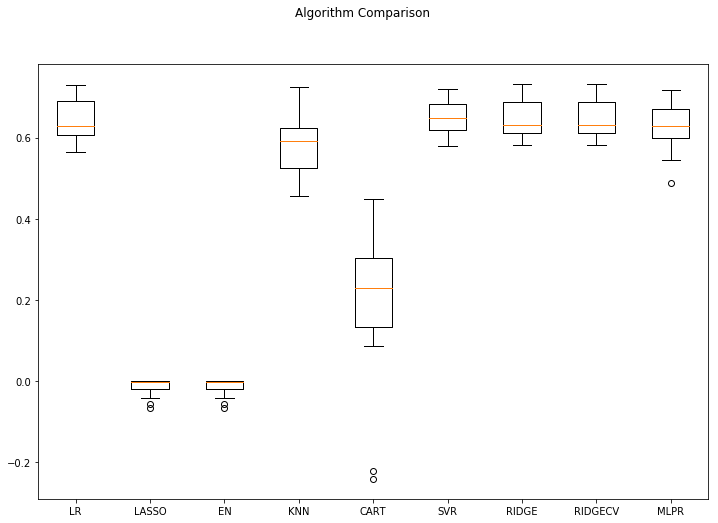

In [39]:
fig = plt.figure(figsize=(12,8))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results1)
ax.set_xticklabels(names1)
plt.show()

Standardizing the dataset

In [40]:
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR', LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledSVR', Pipeline([('Scaler', StandardScaler()),('SVR', SVR())])))
pipelines.append(('ScaledRIDGE', Pipeline([('Scaler', StandardScaler()),('RIDGE', Ridge())])))
pipelines.append(('ScaledRIDGECV', Pipeline([('Scaler', StandardScaler()),('RIDGECV', RidgeCV())])))
pipelines.append(('ScaledMLPR', Pipeline([('Scaler', StandardScaler()),('MLPR', MLPRegressor())])))
results2 = []
names2 = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=score)
    results2.append(cv_results)
    names2.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: 0.640510 (0.051512)
ScaledLASSO: -0.014786 (0.021318)
ScaledEN: -0.014786 (0.021318)
ScaledKNN: 0.581058 (0.074859)
ScaledCART: 0.199202 (0.204626)
ScaledSVR: 0.601032 (0.061832)
ScaledRIDGE: 0.642448 (0.050975)
ScaledRIDGECV: 0.646582 (0.050319)
ScaledMLPR: 0.165606 (0.221514)


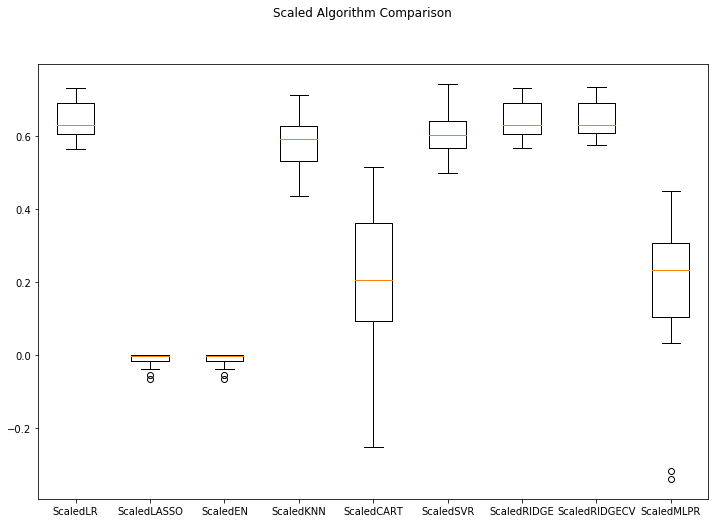

In [41]:
fig = plt.figure(figsize=(12,8))
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results2)
ax.set_xticklabels(names2)
plt.show()

KNN Algorithm tuning

In [42]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
k_values = np.array([1,3,5,7,9,11,13,15,17,19,21])
param_grid = dict(n_neighbors=k_values)
model = KNeighborsRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=score, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.597845 using {'n_neighbors': 11}
0.358865 (0.109193) with: {'n_neighbors': 1}
0.562023 (0.079035) with: {'n_neighbors': 3}
0.580391 (0.073541) with: {'n_neighbors': 5}
0.586578 (0.053678) with: {'n_neighbors': 7}
0.591339 (0.055840) with: {'n_neighbors': 9}
0.597845 (0.048930) with: {'n_neighbors': 11}
0.597824 (0.046092) with: {'n_neighbors': 13}
0.594127 (0.043755) with: {'n_neighbors': 15}
0.597473 (0.038855) with: {'n_neighbors': 17}
0.597390 (0.041282) with: {'n_neighbors': 19}
0.596278 (0.041127) with: {'n_neighbors': 21}


Lasso Algorithm Tuning

In [43]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
alpha_values = np.linspace(0.0004,0.002,15)
param_grid = dict(alpha=alpha_values)
model = Lasso()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=score, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.650397 using {'alpha': 0.0014285714285714286}
0.647807 (0.046904) with: {'alpha': 0.0004}
0.648311 (0.046009) with: {'alpha': 0.0005142857142857143}
0.648627 (0.045275) with: {'alpha': 0.0006285714285714286}
0.648764 (0.044411) with: {'alpha': 0.000742857142857143}
0.649180 (0.043666) with: {'alpha': 0.0008571428571428572}
0.649482 (0.042985) with: {'alpha': 0.0009714285714285714}
0.649830 (0.042563) with: {'alpha': 0.0010857142857142858}
0.650079 (0.042240) with: {'alpha': 0.0012000000000000001}
0.650275 (0.042043) with: {'alpha': 0.0013142857142857144}
0.650397 (0.041906) with: {'alpha': 0.0014285714285714286}
0.650375 (0.041807) with: {'alpha': 0.001542857142857143}
0.650142 (0.041692) with: {'alpha': 0.0016571428571428572}
0.649814 (0.041617) with: {'alpha': 0.0017714285714285716}
0.649661 (0.041518) with: {'alpha': 0.001885714285714286}
0.649714 (0.041480) with: {'alpha': 0.002}


Ridge Algorithm Tuning

In [44]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
alpha_values = [0, 1, 10, 20, 50, 80, 100, 120, 200, 500]
param_grid = dict(alpha=alpha_values)
model = Ridge()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=score, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.649128 using {'alpha': 80}
0.640523 (0.051508) with: {'alpha': 0}
0.642469 (0.050975) with: {'alpha': 1}
0.646620 (0.050321) with: {'alpha': 10}
0.647922 (0.049701) with: {'alpha': 20}
0.648986 (0.048221) with: {'alpha': 50}
0.649128 (0.047121) with: {'alpha': 80}
0.649095 (0.046507) with: {'alpha': 100}
0.649017 (0.045959) with: {'alpha': 120}
0.648504 (0.044186) with: {'alpha': 200}
0.645650 (0.040145) with: {'alpha': 500}


ElasticNet Algorithm Tuning

In [45]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
l1_values = np.linspace(1e-07,1e-05, 15)
param_grid = dict(l1_ratio=l1_values)
model = ElasticNet()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=score, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.634394 using {'l1_ratio': 1e-07}
0.634394 (0.034198) with: {'l1_ratio': 1e-07}
0.634394 (0.034198) with: {'l1_ratio': 8.071428571428572e-07}
0.634393 (0.034197) with: {'l1_ratio': 1.5142857142857145e-06}
0.634392 (0.034196) with: {'l1_ratio': 2.2214285714285716e-06}
0.634391 (0.034196) with: {'l1_ratio': 2.9285714285714287e-06}
0.634390 (0.034195) with: {'l1_ratio': 3.6357142857142858e-06}
0.634389 (0.034194) with: {'l1_ratio': 4.342857142857143e-06}
0.634389 (0.034194) with: {'l1_ratio': 5.05e-06}
0.634388 (0.034193) with: {'l1_ratio': 5.7571428571428574e-06}
0.634387 (0.034192) with: {'l1_ratio': 6.464285714285715e-06}
0.634386 (0.034191) with: {'l1_ratio': 7.171428571428572e-06}
0.634385 (0.034191) with: {'l1_ratio': 7.878571428571429e-06}
0.634385 (0.034190) with: {'l1_ratio': 8.585714285714287e-06}
0.634384 (0.034189) with: {'l1_ratio': 9.292857142857144e-06}
0.634383 (0.034189) with: {'l1_ratio': 1e-05}


Plotting the tunned algorithms

In [46]:
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR', LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso(alpha=0.00145))])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet(l1_ratio=1e-07))])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor(n_neighbors=11))])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledSVR', Pipeline([('Scaler', StandardScaler()),('SVR', SVR())])))
pipelines.append(('ScaledRIDGE', Pipeline([('Scaler', StandardScaler()),('RIDGE', Ridge(alpha=80))])))
pipelines.append(('ScaledRIDGECV', Pipeline([('Scaler', StandardScaler()),('RIDGECV', RidgeCV())])))
pipelines.append(('ScaledMLPR', Pipeline([('Scaler', StandardScaler()),('MLPR', MLPRegressor())])))
results2 = []
names2 = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=score)
    results2.append(cv_results)
    names2.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: 0.640510 (0.051512)
ScaledLASSO: 0.650339 (0.041929)
ScaledEN: 0.634384 (0.034399)
ScaledKNN: 0.595102 (0.048826)
ScaledCART: 0.233946 (0.188620)
ScaledSVR: 0.601032 (0.061832)
ScaledRIDGE: 0.649073 (0.047164)
ScaledRIDGECV: 0.646582 (0.050319)
ScaledMLPR: 0.186852 (0.148452)


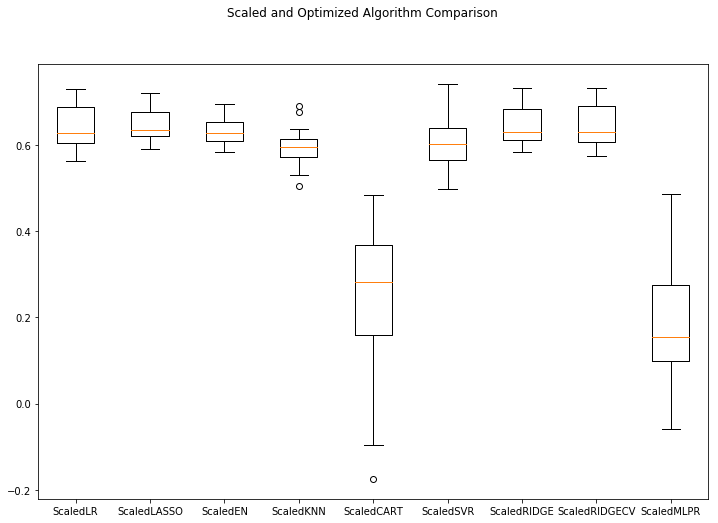

In [47]:
fig = plt.figure(figsize=(12,8))
fig.suptitle('Scaled and Optimized Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results2)
ax.set_xticklabels(names2)
plt.show()

Ensembles

In [48]:
ensembles = []
ensembles.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor(n_neighbors=11))])))
ensembles.append(('ScaledAB', Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostRegressor())])))
ensembles.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
ensembles.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor())])))
ensembles.append(('ScaledET', Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesRegressor())])))
results3 = []
names3 = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=score)
    results3.append(cv_results)
    names3.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledKNN: 0.595102 (0.048826)
ScaledAB: 0.456993 (0.082871)
ScaledGBM: 0.634075 (0.058425)
ScaledRF: 0.579136 (0.069089)
ScaledET: 0.618938 (0.058226)


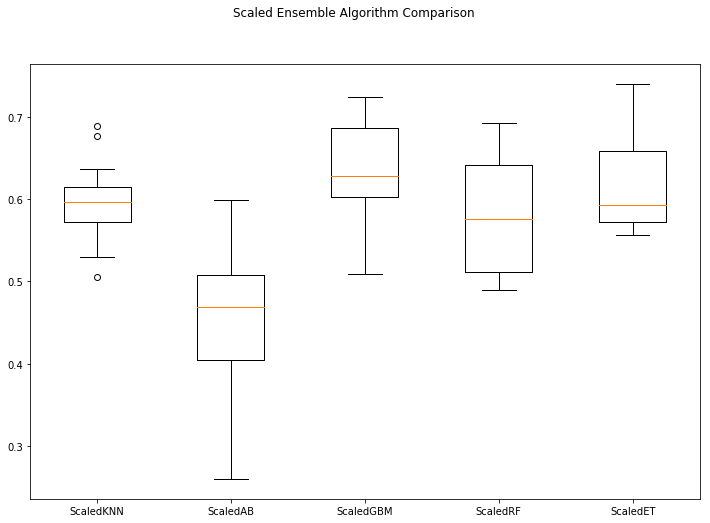

In [49]:
fig = plt.figure(figsize=(12,8))
fig.suptitle('Scaled Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results3)
ax.set_xticklabels(names3)
plt.show()

GBM Algorithm Tuning

In [50]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
param_grid = dict(n_estimators=np.array([20,35,40,45,50,55,60,100]))
model = GradientBoostingRegressor(random_state=seed)
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=score, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.640798 using {'n_estimators': 50}
0.616922 (0.041530) with: {'n_estimators': 20}
0.635921 (0.049455) with: {'n_estimators': 35}
0.638491 (0.050141) with: {'n_estimators': 40}
0.638775 (0.050281) with: {'n_estimators': 45}
0.640798 (0.050850) with: {'n_estimators': 50}
0.640113 (0.053218) with: {'n_estimators': 55}
0.639924 (0.054329) with: {'n_estimators': 60}
0.635532 (0.056785) with: {'n_estimators': 100}


Summarizing all the optimized results

In [51]:
results = []
names = []
pipelines = []

pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR', LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso(alpha=0.00145))])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet(l1_ratio=1e-07))])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor(n_neighbors=11))])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledSVR', Pipeline([('Scaler', StandardScaler()),('SVR', SVR())])))
pipelines.append(('ScaledRIDGE', Pipeline([('Scaler', StandardScaler()),('RIDGE', Ridge(alpha=80))])))
pipelines.append(('ScaledRIDGECV', Pipeline([('Scaler', StandardScaler()),('RIDGECV', RidgeCV())])))
pipelines.append(('ScaledMLPR', Pipeline([('Scaler', StandardScaler()),('MLPR', MLPRegressor())])))
pipelines.append(('ScaledAB', Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostRegressor())])))
pipelines.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor(n_estimators=50))])))
pipelines.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor())])))
pipelines.append(('ScaledET', Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesRegressor())])))

for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=score)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: 0.640510 (0.051512)
ScaledLASSO: 0.650339 (0.041929)
ScaledEN: 0.634384 (0.034399)
ScaledKNN: 0.595102 (0.048826)
ScaledCART: 0.236143 (0.219297)
ScaledSVR: 0.601032 (0.061832)
ScaledRIDGE: 0.649073 (0.047164)
ScaledRIDGECV: 0.646582 (0.050319)
ScaledMLPR: 0.187740 (0.164409)
ScaledAB: 0.474234 (0.089786)
ScaledGBM: 0.640808 (0.050656)
ScaledRF: 0.610984 (0.058460)
ScaledET: 0.623868 (0.057329)


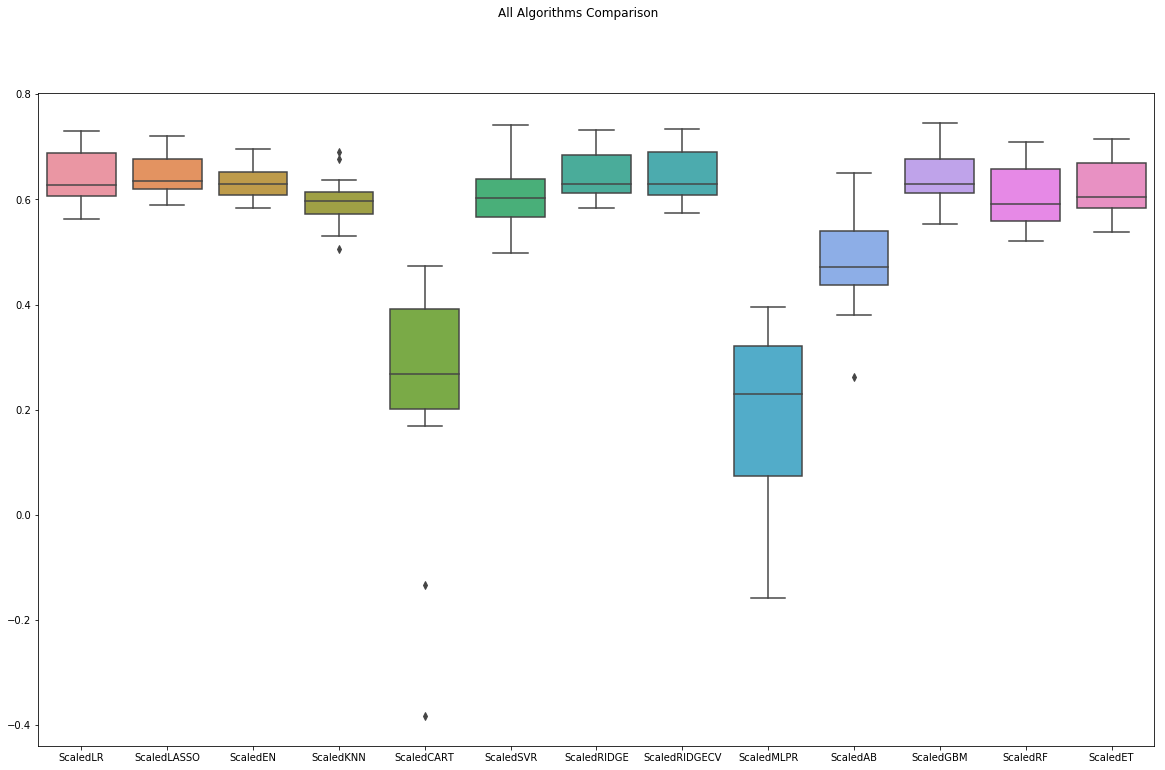

In [52]:
fig = plt.figure(figsize=(20,12))
fig.suptitle('All Algorithms Comparison')
ax = fig.add_subplot(111)
#plt.boxplot(results, widths=0.5)
sns.boxplot(data=results)
ax.set_xticklabels(names)
plt.show()

So our best regressors are Lasso and Ridge

In [53]:
# prepare the model
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = Lasso(alpha=0.00145, random_state=0)
model.fit(rescaledX, Y_train)

Lasso(alpha=0.00145, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=0,
   selection='cyclic', tol=0.0001, warm_start=False)

In [65]:
eval = pd.Series(model.coef_, index=df.columns[:-1]).sort_values()
eval

PctKids2Par             -5.26e-02
PctPopUnderPov          -1.83e-02
MedOwnCostPctIncNoMtg   -1.65e-02
pctWInvInc              -1.57e-02
PctWorkMom              -1.39e-02
RentLowQ                -1.18e-02
agePct12t29             -1.17e-02
racePctWhite            -1.05e-02
PctHousOccup            -9.06e-03
pctWRetire              -7.30e-03
PctFam2Par              -6.25e-03
PctWOFullPlumb          -4.24e-03
PctVacMore6Mos          -3.23e-03
NumImmig                -1.98e-03
indianPerCap            -1.88e-03
PctEmplManu             -1.58e-03
MedYrHousBuilt          -1.18e-03
PctYoungKids2Par        -7.03e-04
PctForeignBorn           0.00e+00
RentHighQ                0.00e+00
RentMedian               0.00e+00
PctUsePubTrans           0.00e+00
NumInShelters            0.00e+00
PctImmigRecent           0.00e+00
PctImmigRec5             0.00e+00
PctImmigRec8            -0.00e+00
PctImmigRec10            0.00e+00
PctRecentImmig           0.00e+00
PctRecImmig5             0.00e+00
PctHousOwnOcc 

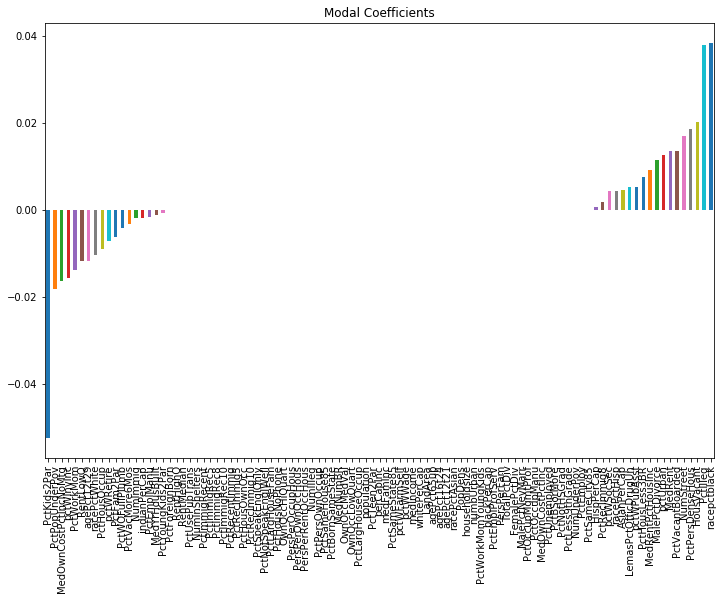

In [66]:
eval.plot(kind='bar', title='Modal Coefficients', figsize=(12,8))

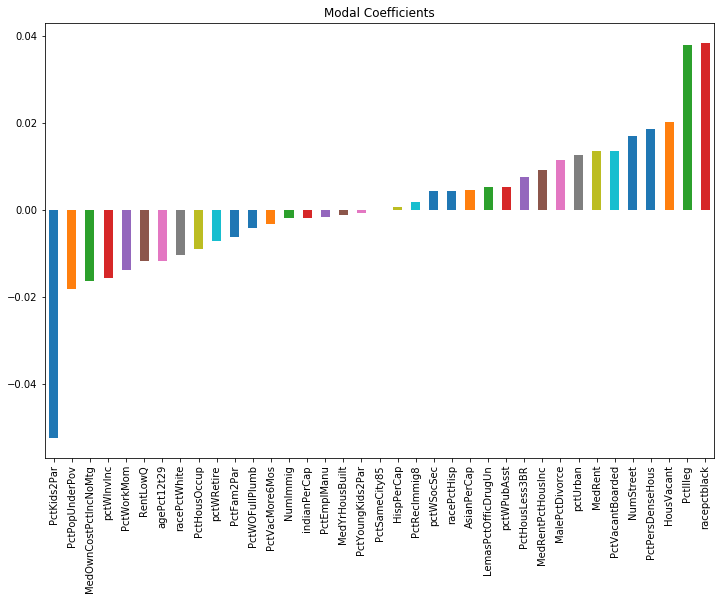

In [68]:
eval2 = eval[np.abs(eval)>1e-6]
eval2.plot(kind='bar', title='Modal Coefficients', figsize=(12,8))

Verifying the Lasso and ElasticNet paths

(see pages pages 69-73 from [The Elements of Statistical Learning](https://web.stanford.edu/~hastie/Papers/ESLII.pdf)

In [55]:
eps = 5e-3

print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(rescaledX, Y_train, eps, random_state=0)

print("Computing regularization path using the positive lasso...")
alphas_positive_lasso, coefs_positive_lasso, _ = lasso_path(rescaledX, Y_train, eps, positive=True, fit_intercept=False)

print("Computing regularization path using the elastic net...")
alphas_enet, coefs_enet, _ = enet_path(rescaledX, Y_train, eps=eps, l1_ratio=0.8, fit_intercept=False)

print("Computing regularization path using the positive elastic net...")
alphas_positive_enet, coefs_positive_enet, _ = enet_path(rescaledX, Y_train, eps=eps, l1_ratio=0.8, positive=True, fit_intercept=False)

Computing regularization path using the lasso...
Computing regularization path using the positive lasso...
Computing regularization path using the elastic net...
Computing regularization path using the positive elastic net...


(0.5534468742250748,
 3.191180883764316,
 -0.07802807201341483,
 0.049939505996933954)

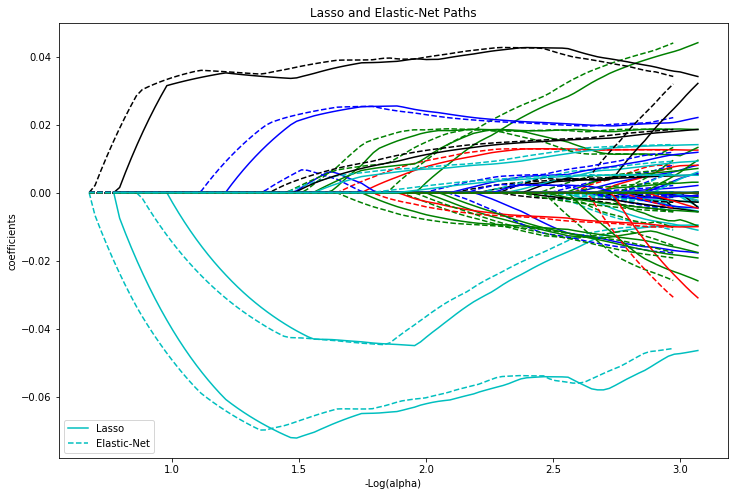

In [56]:
# Display results
plt.figure(figsize=(12,8))
ax = plt.gca()

colors = cycle(['b', 'r', 'g', 'c', 'k'])
neg_log_alphas_lasso = -np.log10(alphas_lasso)
neg_log_alphas_enet = -np.log10(alphas_enet)
for coef_l, coef_e, c in zip(coefs_lasso, coefs_enet, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)
    l2 = plt.plot(neg_log_alphas_enet, coef_e, linestyle='--', c=c)

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso and Elastic-Net Paths')
plt.legend((l1[-1], l2[-1]), ('Lasso', 'Elastic-Net'), loc='lower left')
plt.axis('tight')

(0.655202387883534,
 3.186335383113913,
 -0.08107456050479477,
 0.11391576431591269)

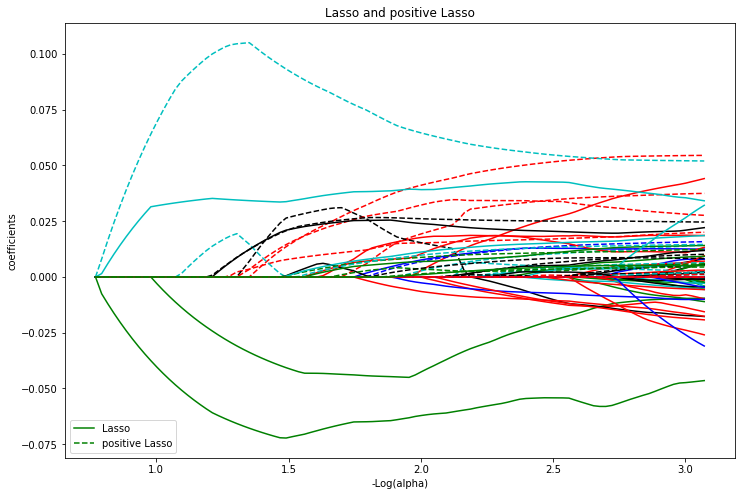

In [57]:
plt.figure(figsize=(12,8))
ax = plt.gca()
neg_log_alphas_positive_lasso = -np.log10(alphas_positive_lasso)
for coef_l, coef_pl, c in zip(coefs_lasso, coefs_positive_lasso, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)
    l2 = plt.plot(neg_log_alphas_positive_lasso, coef_pl, linestyle='--', c=c)

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso and positive Lasso')
plt.legend((l1[-1], l2[-1]), ('Lasso', 'positive Lasso'), loc='lower left')
plt.axis('tight')

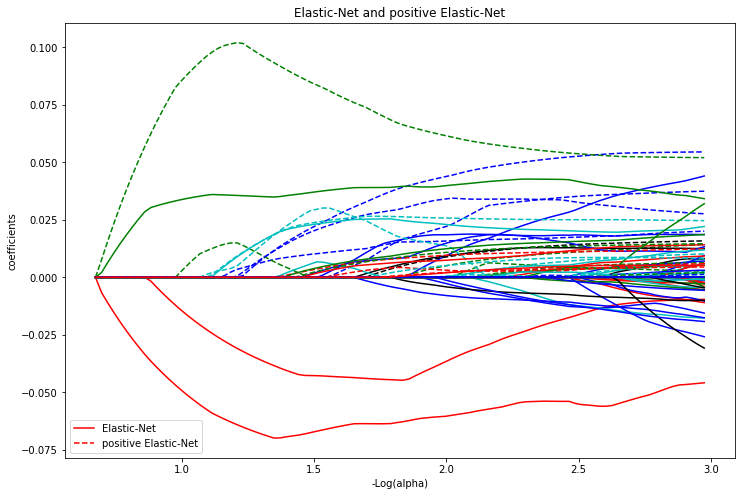

In [58]:
plt.figure(figsize=(12,8))
ax = plt.gca()
neg_log_alphas_positive_enet = -np.log10(alphas_positive_enet)
for (coef_e, coef_pe, c) in zip(coefs_enet, coefs_positive_enet, colors):
    l1 = plt.plot(neg_log_alphas_enet, coef_e, c=c)
    l2 = plt.plot(neg_log_alphas_positive_enet, coef_pe, linestyle='--', c=c)

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Elastic-Net and positive Elastic-Net')
plt.legend((l1[-1], l2[-1]), ('Elastic-Net', 'positive Elastic-Net'),
           loc='lower left')
plt.axis('tight')
plt.show()

In [69]:
# transform the validation dataset
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = Lasso(alpha=0.00145, random_state=0)
model.fit(rescaledX, Y_train)

rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(rescaledValidationX)
print(mean_squared_error(Y_validation, predictions))

0.02094980229518499


Trying Keras Regression (TBF)

In [60]:
# define base model
def baseline_model(input_dim):
    # create model
    model = Sequential()
    model.add(Dense(input_dim, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [61]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model(X.shape[1]), epochs=100, batch_size=5, verbose=0)

NameError: name 'KerasRegressor' is not defined

kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(estimator, X, y, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [ ]:
# evaluate model with standardized dataset
numpy.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, X, Y, cv=kfold)
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))